In [1]:
import os
import yaml
import time
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from linearqmml.parsing import LammpsParser

from linearqmml.regression import ridge_regression
from linearqmml.regression import collected_ridge_regression
from linearqmml.regression import kernel_ridge_regression
from linearqmml.regression import collected_kernel_ridge_regression

from linearqmml.plotting import plot_distance_histogram
from linearqmml.plotting import plot_descriptions
from linearqmml.plotting import plot_morse_performance

from linearqmml.utils import get_morse_potential
from linearqmml.utils import tqdm_wrap

In [2]:
from linearqmml.smearing import triangle_pdf
from linearqmml.smearing import triangle_cdf

In [3]:
from linearqmml.smearing import RealspaceHandler
from linearqmml.smearing import distance_matrix_periodic

# Parsing

In [4]:
import linearqmml
package_root = '/'.join(linearqmml.__file__.split('/')[:-2])
example_dir = package_root + '/examples'
assert os.path.isdir(example_dir)

run_stem = 'copper_liquid'
element_symbols = ['Cu']
element_aliases = {'1': 'Cu'}

parsing_handler = LammpsParser(root=example_dir,
                               stem=run_stem, 
                               element_symbols=element_symbols,
                               element_aliases=element_aliases)
print(LammpsParser.__doc__)
print(LammpsParser.__init__.__doc__)


    Parse LAMMPS .xyz and dumps. Supports serialization to yaml.

    Suggest usage:
    1. process_dump()
    2. flatten_entries() to retrieve keys, ase Atoms objects, and energies
    

        Args:
            root (str): Path to working directory.
            stem (str): Prefix for dataset filenames.
            element_symbols (list): List of element symbols (str).
            element_aliases (dict): Optional mapping of aliases
                for element symbols. LAMMPS users typically use integers
                as element identifiers in inputs/outputs. Defaults to
                integer: symbol mapping based on alphabetical sorting plus
                symbol: symbol identity mapping.
        


In [5]:
filename = '{}/{}.dump'.format(parsing_handler.root, parsing_handler.stem)
parsing_handler.process_dump(filename=filename)
print(LammpsParser.process_dump.__doc__)

100%|██████████| 2601/2601 [00:01<00:00, 1575.85it/s]


        Process custom LAMMPS dump file. Obtain by LAMMPS commands:
            "compute peratom all pe/atom"
            "compute pe all reduce sum c_perat"
            "dump fix_dump all custom 1 ${root}/${stem}.dump id x y z c_perat"

        Args:
            filename: Optional filename. Defaults to [root]/[stem].dump
        


In [6]:
local=False
indices = None
key_subset = None
flattened_entries = parsing_handler.flatten_entries(local=local,
                                                    indices=indices,
                                                    key_subset=key_subset)
keys, geometries, energies = flattened_entries
print(LammpsParser.flatten_entries.__doc__)


        Flattens entries into lists e.g. for machine learning.

        Args:
            local (bool): uses list of energies if available instead of sum.
            indices (list): optional subset of integers for slicing the
                flattened list of keys.
            key_subset (list): optional list of keys with which to take subset.

        Returns:
            keys (list): Entry names. Often simply the timesteps from LAMMPS.
            geometries (list): List of ase Atoms objects.
            energies (list): List of energies or lists of local energies.
        


In [7]:
df = pd.DataFrame(columns=['Energy'], index=keys, data=energies)
df['Geometry'] = geometries
df.tail()

,Energy,Geometry
259600,-320.92193,"(Atom('Cu', [5.727547529418534, 7.024117529418..."
259700,-317.78178,"(Atom('Cu', [5.5855575294185345, 7.19925752941..."
259800,-320.83003,"(Atom('Cu', [5.329797529418534, 7.255487529418..."
259900,-322.28102,"(Atom('Cu', [5.320797529418535, 7.350327529418..."
260000,-324.74018,"(Atom('Cu', [5.055277529418534, 7.416527529418..."


# Triangle function demo

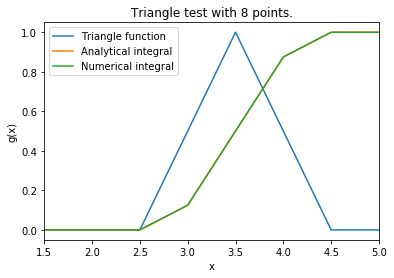

In [8]:
n_test = 8

r_min = 1.5
r_max = 5

x_test = np.linspace(r_min, r_max, n_test).astype(np.float64)
mu_test = 3.5  # center of distribution
sigma_test = 1  # width (radius) of broadening

pdf = triangle_pdf(x_test, mu_test, sigma_test)  # function
cdf = triangle_cdf(x_test, mu_test, sigma_test)  # integral
trapz = [np.trapz(triangle_pdf(x_test[:i+1], mu_test, sigma_test), 
                  x_test[:i+1])
         for i in range(len(x_test))]

plt.title('Triangle test with {} points.'.format(n_test))
plt.plot(x_test, pdf, label='Triangle function')
plt.plot(x_test, cdf, label='Analytical integral')
plt.plot(x_test, trapz, label='Numerical integral')
plt.xlabel('x')
plt.ylabel('g(x)')
plt.xlim(r_min, r_max)
plt.legend()
plt.show()

# Binning Demo

In [9]:
n_bins = 50
r_min = 1.5
r_max = 5.0

sigma_test = 0.1  # width (radius) of broadening
bin_width = (r_max - r_min) / n_bins

sigma_factor = sigma_test/bin_width

rsh = RealspaceHandler(sigma_factor=sigma_factor,
                       lower_bound=[r_min],
                       upper_bound=[r_max],
                       resolutions=[n_bins])

Number of bins = 50
Active range (bins) 30:34


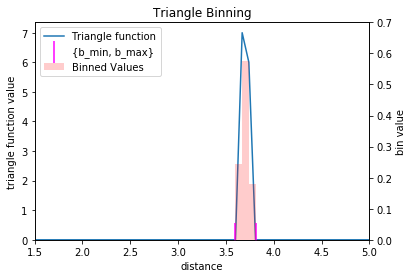

In [10]:
mu_test = 3.7  # center of test distribution

delta = sigma_test
b_min = np.floor((mu_test - delta - r_min) / bin_width).astype(int)
b_max = np.ceil((mu_test + delta - r_min) / bin_width).astype(int) + 1
b_min = max(0, b_min)
b_max = min(n_bins+1, b_max)
# min and max indices of bin_edges to consider, based on distance delta
# for triangle function, this is trivially equal to sigma
bin_values = rsh.smear(mu_test, sigma_test, bin_width, r_min, b_min, b_max)

bin_edges = np.arange(-5,n_bins+5)/n_bins*(r_max-r_min)+r_min
print('Number of bins =', n_bins)
print('Active range (bins) {}:{}'.format(b_min, b_max))
fig, ax = plt.subplots(figsize=(6,4))
ax2 = ax.twinx()
ax.set_title('Triangle Binning'.format(n_test))
ax.plot(bin_edges, triangle_pdf(bin_edges, mu_test, sigma_test), 
        label='Triangle function')
ax2.scatter([r_min + bin_width * b_min, r_min + bin_width * (b_max-1)], 
            [0.02,0.02], 
            c='magenta', marker='|', s=500, 
            label='{b_min, b_max}')
ax2.plot([], [], label='Triangle function')
ax2.bar(np.arange(b_min, b_max) * bin_width + r_min, bin_values, 
        width=0.07, color='red', alpha=0.2,
        align='edge', label='Binned Values')
ax.set_xlabel('distance')
ax.set_ylabel('triangle function value')
ax2.set_ylabel('bin value')
ax.set_xlim(r_min, r_max)
ax2.set_xlim(r_min, r_max)
ax.set_ylim(0, ax.get_ylim()[1])
ax2.set_ylim(0, 0.7)
ax2.legend()
plt.show()

# Histograms and Distance Matrices Demo

In [11]:
sample_geometry = geometries[0]
dm = distance_matrix_periodic(sample_geometry.get_positions().astype(np.float64),
                              sample_geometry.cell.diagonal().astype(np.float64))
print('Distance Matrix shape:', dm.shape)
sample_distances = dm[np.logical_and(dm>r_min, dm<r_max+0.1)]
print('Number of distances within r_min < r < r_max: ', len(sample_distances))

Distance Matrix shape: (108, 108)
Number of distances within r_min < r < r_max:  5704



    Histogram of pairwise distances, scaled by 1/r^2. The histogram converges
    to the number density at larger distances.
    
    Args:
        distances (list): flattened list of distance observations.
        n_bins (int): Number of bins for histogram. Defaults to 50.
        ax: optional matplotlib axis object on which to plot.

    Returns:
        fig & ax: new matplotlib figure & axis if ax is not specified.
    


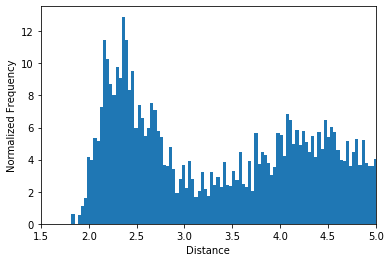

In [12]:
fig, ax = plt.subplots(figsize=(6,4))
plot_distance_histogram([sample_distances], n_bins=100, ax=ax)
ax.set_ylabel('Normalized Frequency')
ax.set_xlabel('Distance')
ax.set_xlim(r_min, r_max)
print(plot_distance_histogram.__doc__)

# 1D Representation vs. Distance Histogram

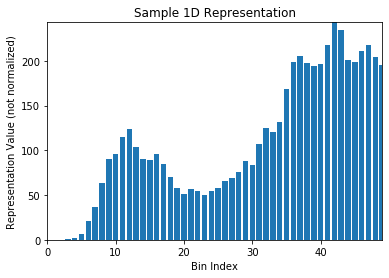

In [13]:
sample_representation = rsh.describe_1d(sample_geometry)

plt.bar(np.arange(n_bins), sample_representation, width=0.8)
plt.xlim(0, 49)
plt.ylim(0, np.max(sample_representation))
plt.xlabel('Bin Index')
plt.ylabel('Representation Value (not normalized)')
plt.title('Sample 1D Representation')
plt.show()

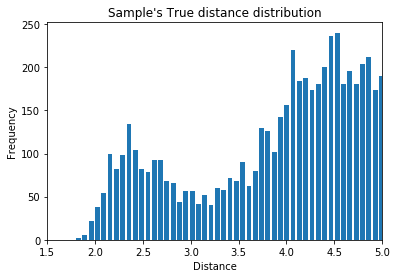

In [14]:
plt.hist(sample_distances, width=0.05, bins=50)
plt.xlim(1.5, 5)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title("Sample's True distance distribution")
plt.show()

# Regression Demo


In [16]:
repr_columns = ['x_{}'.format(i) for i in range(n_bins)]
repr_df = pd.DataFrame(columns=repr_columns)

n = 50
entries = sorted(zip(keys, geometries), key=lambda x: int(x[0]))[:n]

for key, geometry in tqdm_wrap(entries):
    representation = rsh.describe_1d(distances)
    repr_df.loc[key] = representation

  0%|          | 0/50 [00:00<?, ?it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'get_positions'

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
plot_descriptions(repr_df.values, rsh.bin_ranges[0]+rsh.lower_bound[0], ax=ax)
ax.set_ylim(0, 250)
#ax.set_xlim(rsh.lower_bound[0], rsh.upper_bound[0])
ax.set_ylabel('g(r)')
ax.set_xlabel('r')

In [ ]:
frac_train = 0.8
n_train = int(len(repr_df) * frac_train)

x_train = repr_df.iloc[:n_train].values
y_train = energies[:n_train]

x_test = repr_df.iloc[n_train:].values
y_test = energies[n_train:len(repr_df)]

In [ ]:
coefficients, predictions, input_mean = ridge_regression(x_train, 
                                                         y_train, 
                                                         lambda_=1e-1)

test_predictions = np.dot(coefficients, x_test.T)

r_range = rsh.bin_ranges[0]+rsh.lower_bound[0]
plot_morse_performance(coefficients, 
                       test_predictions, 
                       y_test, 
                       repr_df.values, 
                       r_range)